# 폐렴 진단기 성능개선
---

85% 이상의 정확도를 가진 폐렴 진단기를 모델링 해보자( ᐛ )و

## STEP 0. 설계
---

#### 1. 목표
- 전체목표 : 85% 이상의 Accuracy를 보이는 의료영상 처리 CNN 기반 모델를 만들었다.
- 세부목표
    - 전처리 : Data Augmentation를 도입하여 본다.
    - 모델 설계 및 실험
        - 기존에 사용하지 않았던 다양한 Convolution Layer를 이용하여 모델을 설계해 본다.
        - BatchNormalization과 Dropout의 유무에 따른 결과 차이를 확인해 본다.
        - 하이퍼 파라미터(convolution filter, channel number, activation, class_weight, optimizer, epoch, learning rate)에 따른 결과 차이를 확인해 본다.
        - 이때, 위의 결과 차이는 test set에 대한 accuary와 recall, 학습 history의 그래프를 통해 확인한다.

#### 2. 배경지식
- Data Augmentation(데이터 증강)
    - 데이터 증강이란 이미지 혹은 비디오의 데이터 정보를 임의로 변형하여 다른 정보로 만들어 데이터의 양을 증가시키는 것이다.
    - 데이터 증강은 모델 학습시킬 때, 데이터의 양이 부족한 경우 사용될 수 있으며 이는 모델의 학습 결과를 향상 시키고, 과접합(Overfitting)를 방지하는 효과를 보인다.
    - 데이터 증강을 시키는 방법으로는 crop, flipping, rotation, shifting, re-scaling, shearing, stretchin등이 있다.
    - keras의 ImageDataGenerator를 활용하면 아래와 같이 간다히 임의변형 된 이미지를 얻을 수 있다.
    

(1, 683, 1024, 3)


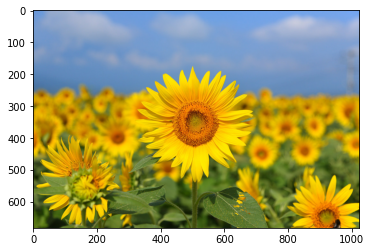

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#define a function to display 9 augmented images

def show_image(iterator, title):
    # generate samples and plot
    for i in range(3):
        plt.subplot(330 + 1 + i)
        batch = iterator.next()
        image = batch[0].astype('uint8')
        plt.axis('off')
        plt.imshow(image)
    plt.suptitle(title, fontsize=15)
    plt.show()
    
#load and display the original image
img = load_img('./img/sunflower.jpg') 
plt.imshow (img)

data = img_to_array(img) 
samples = np.expand_dims(data, 0)
print(samples.shape)

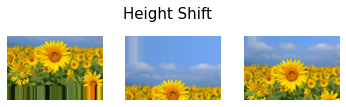

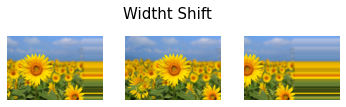

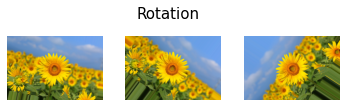

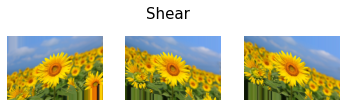

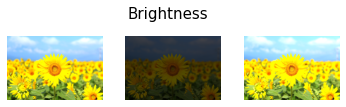

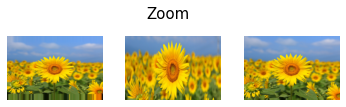

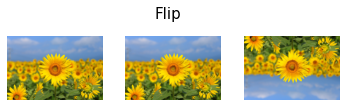

In [30]:
# height_shift_range
datagen_height_shift = ImageDataGenerator(height_shift_range=0.5)
iterator_height_shift = datagen_height_shift.flow(samples, batch_size=1,
                                                 save_to_dir='./img',
                                                 save_prefix='height_shift_')
show_image(iterator_height_shift, 'Height Shift')

# width_shift_range
datagen_width_shift = ImageDataGenerator(width_shift_range=0.5)
iterator_width_shift = datagen_width_shift.flow(samples, batch_size=1)
show_image(iterator_width_shift, 'Widtht Shift')

# rotation_range 
datagen_rotation = ImageDataGenerator(rotation_range = 90)
iterator_rotation = datagen_rotation.flow(samples, batch_size=1)
show_image(iterator_rotation, 'Rotation')

# shear_range 
datagen_shear = ImageDataGenerator(shear_range = 50)
iterator_shear = datagen_shear.flow(samples, batch_size=1)
show_image(iterator_shear, 'Shear')

# brightness_range 
datagen_brightness = ImageDataGenerator(brightness_range = [0.3,1.9])
iterator_brightness = datagen_brightness.flow(samples, batch_size=1)
show_image(iterator_brightness, 'Brightness')

# zoom_range
datagen_zoom = ImageDataGenerator(zoom_range = [0.5,1.5])
iterator_zoom = datagen_zoom.flow(samples, batch_size=1)
show_image(iterator_zoom, 'Zoom')

# flip
datagen_flip =ImageDataGenerator(horizontal_flip=True,vertical_flip=True)
iterator_flip = datagen_flip.flow(samples, batch_size=1)
show_image(iterator_flip, 'Flip')

- Convolution Layer의 종류
    - Convolution
        - <img src="https://user-images.githubusercontent.com/16831323/110231152-33a1f100-7f59-11eb-9f91-e1222cdbb035.gif" width="300px">
        - Filter와 Feature map(input data) 사이에 합성곱 연산을하여 출력값을 계산하는 방식이다.
        - 이 기본적인 Convolution layer는 아래와 같은 문제점을 가지고 있다.
            - Expensive cost : 네트워크가 깊어지고 채널이 증가할수록 연산량이 증가한다.
            - Dead channels : 신경망의 학습과정에서 출력 결과에 영향을 거의 주지 않는 노드가 나타날 수 있는데, 이것이 채널 단위에서 발생할 수도 있다. 
            - Low Correlation between channel : 각 필터는 입력 영상의 모든 채널을 사용하지만, 모든 채널과 필터 쌍이 높은 correlation을 가질 수는 없다. 이로인하여, 학습 수렴 속도가 저하되고, 불필요한 필터와 연산이 생성된다.
        - 이러한 문제를 해결하기 위하여 연산량을 경량화 시키면서도 유의미한 데이터를 유지하는 다양한 기법들이 등장하게 되었다.
        - [tf.keras.layers.Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)
    - Dilated Convolutions (atrous Deconvolution)
        - <img src="https://user-images.githubusercontent.com/16831323/110232822-72d53f80-7f63-11eb-86a2-c82163526942.gif" width="300px">
        - 기존 필터가 수용하는 픽셀 사이에 간격을 두어, Receptive Field를 늘리는 방식이다.
        - 동일한 Receptive Field에 대하여 기존의 convolution layer보다 적은 계산 비용을 가진다.
        - real-time segmentation 분야같이 넓은 view와 짧은 연산시간을 요구하는 분야에 많이 사용된다.
        - [tf.nn.atrous_conv2d](https://www.tensorflow.org/api_docs/python/tf/nn/atrous_conv2d)
    - Transposed Convolution(Deconvolution or fractionally strided convolution)
        - <img src="./assets/03_transposed_convolution.png" width="350px">
        - Transposed Convolution은 기존의 convolution과 반대로 진행된다.
        - 기존의 convolution layer의 경우 filter와 input data간의 convolution 연산이 종료되면 데이터의 크기가 줄어든다.(padding=0인 경우) 반면 Transposed convolution은 filter를 transpose한 상태로 input data와 convolution 연산을 진행한기 때문에 data의 크기가 커지는 up-sampling 효과를 볼 수 있다.
        - CNN을 사용한 decoder, 이미지의 해상도를 높이는 super resolution에서 사용된다.
        - [tf.keras.layers.Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose)
    - Separable Convolution
        - <img src="./assets/04_separable_convolution.png" width="500px">
        - Separable Convolution의 기본 아이디어는 커널의 연산을 분해야여 여러 단계로 만드는 것이다.
        - $$ y = conv(x,k)\\ k = dot(k1, k2)\\ y = conv(conv(x, k1), k2)$$
        - 작게 잘려진 커널을 이용하면, 실제적인 연산 횟수가 줄어들어 계산의 복잡성이 줄어들고 네트워크가 더 빠르게 실행되도록 한다. 다만, 모든 커널을 두개의 작은 커널로 분해할 수 없다는 문제점을 가진다.
        - Separable Convolution이 사용되는 대표적은 사용처는 Sobel Mask가 있다.
    - Depthwise Convolution
        - <img src="./assets/05_deptwise_convolution.png" width="350px">
        - 기존의 convolution layer의 거쳐 생성된 output data는 모든 input data의 채널의 영향을 받게 된다. 즉 특정 채널만이 가지는 특정한 feature를 추출하는 것이 불가능 했다.
        - Depthwise convolution은 각 단일 채널에 대해서만 수행되는 필터를 사용함으로써 위의 문제를 해결하고자 한다.
        - 위의 그림과 같이, (8,8,3)인 입력에 대하여 (3,3,3) 필터를 적용한다면 기존의 convolution layer(padding=1, stride=1)를 통과한다면 결과는 (8,8,1)이 될 것이다. 반면, deptwise convolution layer는 각 채널별로 데이터와 커널이 분리되여 convolution 연산이 진행되고 이 결과를 합쳐 (8,8,3)의 결과를 얻게된다.
        - input=(8,8,3)이고 filter=(3,3,3), 원하는 출력이 (8,8,3)이라면 기존의 convolution layer에서의 파라미터의 수는 `3x3x3x3=81`이 될 것이고, depthwise convolution layer에서의 연산량은 `3x3x3 = 27`이 될 것이다.
        - [tf.keras.layers.DepthwiseConv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/DepthwiseConv2D)
    - Depthwise Separable Convolution
        - <img src="./assets/06_deptwise_separable_convolution.png" width="350px">
        - Deptwise convolution의 결과값을 하나로 합치어 하나의 채널로 내보낸다.
        - convolution layer와 거의 유사하게 동작하지만 파라미터가 훨씬 적다.
        -   input=(8,8,3)이고 filter=(3,3,3), 원하는 출력이 (8,8,3)이라면 depthwise separable convolution에서의 파라미터의 수는 `3x3x3+3x3=36`이다.
        - [tf.keras.layers.SeparableConv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SeparableConv2D)
    - Pointwise Convolution
        - <img src="./assets/07_pointwise_convolution.png" width="300px">
        - 1x1 convolution
        - Deptwise가 공간방향으로 covolution을 진행하는 반면, Pointwise는 채널방향으로 covolution을 진행한다. 따라서 출력 데이터의 크기는 입력 데이터와 같으면서 channel의 수만 줄어든다.


#### 3. 프로젝트 설계
1. Data Preprocessing
    - Data Augmentation
        - 기존의 이미지를 변형시켜 새로운 데이터를 생성한다.
        - 새로 생성된 이미지는 `workspace/data/aurgmentation`에 저장한다.        
    - Load Data 
        - 모든 이미지의 주소를 불러와 filepaths를 생성한다.
        - filepaths를 이용하여 이미지 데이터와 라벨로 구성된 데이터 셋을 생성한다.
        - 실험을 위하여 총 세종류의 데이터셋을 구성하며, train : val : test = 7 : 1.5 : 1.5가 되도록 한다.
            1. [D1] 기본
                - Augmentation으로 생성되지 않은 이미지로 구성
                - 이미지의 크기 : 180x180
            2. [D2] Data Augmentation 추가
                - Augmentation으로 생성된 이미지를 추가
                - 이미지의 크기 : 180x180 
            3. [D3] 이미지 크기 증가
                - Augmentation으로 생성되지 않은 이미지로 구성
                - 이지미의 크기 : 360x360
    - 데이터 시각화
        - 각 데이터 셋의 데이터를 시각화하여 확인한다.
2. 모델링
    1. 모델 구성 및 선정
        - D1을 입력으로 하는 모델을 다음과 같이 구성한다.
        - ![08_summary](./assets/08_model_summary.png)
        - 위의 그림에서 주황색으로 표시된 Sequential은 [Conv2D]-[Conv2D]-[BatchNorm]-[MaxPool2]로 구성된다. 
        - 위의 그림에서 하늘색으로 표시된 Sequential은 [Dense]-[BatchNormalization]-[Dropout]으로 구성된다.
    2. Convolutaion Layer에 다른 성능차이 확인
        - 모델에서 Convolution Layer가 사용된 부분을 다른 종류의 Convolution Layer(SeparableConv2D, DepthwiseConv2D)로 대체하여 차이를 비교하여 본다.
        - 비교에 사용하는 지표는 recall, accuracy, train time, 학습 history의 그래프, 파라미터의 수이다.
        - 가장 성능이 좋은 모델을 이후의 실험에 사용한다. 이때, recall과 accuracy의 평균이 높은 것을 성능이 좋다고 판단한다.
    2. BatchNormalization과 Dropout에 따른 성능차이 확인
        -  BatchNormalization과 Dropout에 따른 성능차이를 확인해보기 위하여, [1.모델 구성 및 선정]에서 선택된 모델에 대해 다음 항목들을 적용시킨 후 실험을 수행한다. 
            1. 모델에서 BatchNormalization과 Dropout을 모두 제거한다.
            2. 모델에서 BatchNormalization을 모두 제거한다.
            3. 모델에서 Dropout을 모두 제거한다.
        - 위 실험을 통하여 성능을 확인하여 보고, 가장 성능이 좋은 모델을 이후 실험에 사용한다.
    3. 하이퍼 파라미터(kernel size, class_weight)에 따른 결과 차이를 확인한다.
        - 각 하이퍼 파라미터의 변화에 따른 accaury와 recall의 변화를 관찰해 본다.
3. 학습 데이터에 따른 모델 성능확인
    - 위 실험들을 통하여 선정된 모델을 활용하여 학습 데이터에 따라 모델의 성능이 어떻게 변하는지 확인해 본다.
    - Preprocessing 과정에서 생성한 3개의 데이터셋을 활용하여, 구조가 같은 3개의 모델을 학습시킨 후 테스트 데이터로 모델을 평가해 본다. 
    - 성능 평가는 recall, accuary, 학습 history 그래프를 활용하여 진행한다.

#### 4. enviroment setting

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import re
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import timeit

# initialization gpu ########################################################
def init_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
      try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
          tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs\n\n")
      except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e, "\n\n")
        
init_gpu()

1 Physical GPUs, 1 Logical GPUs




- time count function as decorator

In [2]:
def timer(func):
    def wrapper(*args, **kwargs):
        start_time = timeit.default_timer() # 시작 시간 체크
        result = func(*args, **kwargs)
        terminate_time = timeit.default_timer() # 종료 시간 체크  
        return result, terminate_time - start_time
    return wrapper

- set workspace path

In [3]:
workspace_path = os.getenv('HOME') + '/workspace/aiffel-exploration-workspace/E14_image_classification'
data_dir_path = workspace_path + '/data'
data_path = data_dir_path + '/combine'
aurgmentation_path = data_dir_path + '/aurgmentation'

- random seed 정의

In [4]:
seed = 2021

## STEP 1. Data Preprocessing
---

### 1. Data Augmentation
`data/train` 하위의 데이터를 읽어 새로운 데이터를 생성한다.

#### 1. 데이터 생성을 위한 변수 결정
- 데이터 생성에 적용할 규칙을 생성할 데이터의 특성에 맞게 결정할 필요가 있다.
- ImageDataGenerator의 파라미터로 생성되는 이미지의 규칙을 설정할 수 있는 값들은 아래와 같다.
    - rotation_range : 램덤회전에 사용되는 회전 범위
    - width_shift_range : 이미지를 램덤으로 가로 이동 시킬 범위. float 값이 들어온다면 이미지 가로 길이에 대한 비율을 의미한다.
    - height_shift_range: 이미지를 램덤으로 세로 이동 시킬 범위. float 값이 들어온다면 이미지의 세로 길이에 대한 비율을 의미한다.
    - brightness_range : 램덤하게 밝기를 변화시킬 범위.
    - shear_range : shearing 각도 범위. 
    - zoom_range : 램덤으로 줌(확대/축소)를 할 범위.
    - horizontal_flip : 상하대칭 여부
    - vertical_flip : 좌우대칭 여부
- 이들 중 폐렴여부 판단의 위한 x-ray 이미지에 사용할만한 요소는 rotation_range, width_shift_range, height_shift_range, zoom_range이 적당해 보인다.
- 폐렴 판정을 위해서는 흉강 전체를 봐야하기 때문에, 각 요소의 값이 너무 크지 않도록 조정할 필요가 있다.

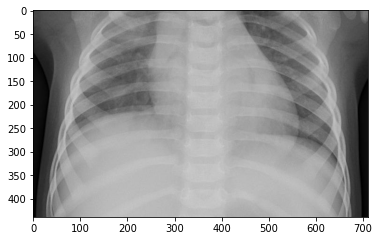

In [62]:
# load sample image
img = load_img(data_path + '/PNEUMONIA/img/person1_bacteria_1.jpeg') 
plt.imshow (img)

In [29]:
def show_image(iterator):
    # generate samples and plot
    for i in range(9):
        plt.subplot(330 + 1 + i)
        batch = iterator.next()
        image = batch[0].astype('uint8')
        plt.axis('off')
        plt.imshow(image)
    plt.show()
    
samples = np.expand_dims(img_to_array(img), 0)
print(samples.shape)

(1, 439, 712, 3)


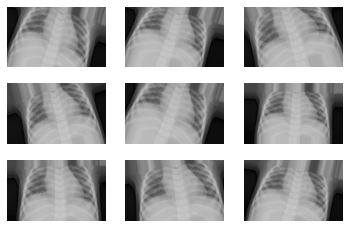

In [42]:
datagen = ImageDataGenerator(rotation_range=30, 
                             width_shift_range=0.05, 
                             height_shift_range=0.05, 
                             zoom_range=[1, 1.3])
iterator = datagen.flow(samples, batch_size=1)
show_image(iterator)

생성된 이미지가 모델학습에 사용하기 적당해 보인다.

#### 2. 데이터 생성
- 기존 데이터를 읽어들여 그를 변형한 새로운 데이터를 생성한다.
- 생성된 데이터는 `data/aurgmentation` 하위에 기존 데이터와 같은 디렉토리 구조로 저장된다.

In [5]:
!ls data/combine

NORMAL	PNEUMONIA


- ImageDataGenerator 정의

In [43]:
datagen = ImageDataGenerator(rotation_range=30, 
                             width_shift_range=0.05, 
                             height_shift_range=0.05, 
                             zoom_range=[1, 1.3])

- NORMAL 데이터 생성

In [66]:
normal_set = datagen.flow_from_directory(
    data_path+'/NORMAL',
    target_size = (180, 180),
    batch_size = 100,
    save_to_dir=aurgmentation_path+'/NORMAL',
    class_mode=None)
len(normal_set)

Found 1583 images belonging to 1 classes.


16

In [80]:
for i in tqdm(range(len(normal_set))):
    _ = next(normal_set)

100%|██████████| 16/16 [00:42<00:00,  2.66s/it]


In [85]:
print(f"aurgmentation/NORMAL의 파일 개수 : {len(next(os.walk(aurgmentation_path+'/NORMAL'))[2])}")

aurgmentation/NORMAL의 파일 개수 : 1583


- PNEUMONIA 데이터 생성

In [86]:
pneumonia_set = datagen.flow_from_directory(
    data_path+'/PNEUMONIA',
    target_size = (180, 180),
    batch_size = 100,
    save_to_dir=aurgmentation_path+'/PNEUMONIA',
    class_mode=None)
len(pneumonia_set)

Found 4273 images belonging to 1 classes.


43

In [87]:
for i in tqdm(range(len(pneumonia_set))):
    _ = next(pneumonia_set)

100%|██████████| 43/43 [01:14<00:00,  1.74s/it]


In [88]:
print(f"aurgmentation/PNEUMONIA 파일 개수 : {len(next(os.walk(aurgmentation_path+'/PNEUMONIA'))[2])}")

aurgmentation/PNEUMONIA 파일 개수 : 4273


### 2. Data Load

- 모든 이미지의 주소를 불러와 filepaths에 label과 함께 저장한다. 이때, label은 폐렴이면 True, 아니라면 False로 지정한다.

In [5]:
filepaths = {
    'origin' : {
        'normal': tf.io.gfile.glob(data_path + '/NORMAL/img/*'),
        'pneumonia': tf.io.gfile.glob(data_path + '/PNEUMONIA/img/*')
    },
    'aurgmentation' : {
        'normal': tf.io.gfile.glob(aurgmentation_path + '/NORMAL/*'),
        'pneumonia': tf.io.gfile.glob(aurgmentation_path + '/PNEUMONIA/*')
    }
}
filepaths['origin']['normal'][0], filepaths['aurgmentation']['normal'][0]

('/home/aiffel-dj1/workspace/aiffel-exploration-workspace/E14_image_classification/data/combine/NORMAL/img/NORMAL2-IM-0196-0001.jpeg',
 '/home/aiffel-dj1/workspace/aiffel-exploration-workspace/E14_image_classification/data/aurgmentation/NORMAL/_1083_5627436.png')

- 데이터셋 생성에 필요한 함수 정의

In [6]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-3] == "PNEUMONIA" or parts[-2] == "PNEUMONIA"

In [7]:
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

In [8]:
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [9]:
def split_train_test_val(data):
    train, test = train_test_split(data,
                                   test_size=0.3,
                                   random_state=seed)
    test, val = train_test_split(test, test_size=0.5, random_state=seed)
    return train, test, val

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16

In [11]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size,seed=seed)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [12]:
def get_dataset(filepaths):
    train_filepaths, test_filepaths, val_filepaths = split_train_test_val(filepaths)
    
    train_ds = tf.data.Dataset.from_tensor_slices(train_filepaths)
    val_ds = tf.data.Dataset.from_tensor_slices(val_filepaths)
    
    test_ds = tf.data.Dataset.from_tensor_slices(test_filepaths)
    test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    test_ds = test_ds.batch(BATCH_SIZE)

    
    return {
        'train': prepare_for_training(train_ds.map(process_path, num_parallel_calls=AUTOTUNE)),
        'test': test_ds,
        'val': prepare_for_training(val_ds.map(process_path, num_parallel_calls=AUTOTUNE)),
        'TRAIN_IMG_COUNT' : len(train_filepaths),
        'VAL_IMG_COUNT' : len(val_filepaths),
        'TEST_IMG_COUNT' : len(test_filepaths)
    }

In [13]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(7,7))
    for n in range(16):
        ax = plt.subplot(4,4,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

#### [D1] 데이터셋 생성
- Augmentation으로 생성되지 않은 이미지로 구성
- 이미지의 크기 : 180x180

In [77]:
filepaths_origin = filepaths['origin']['normal'] + filepaths['origin']['pneumonia']
print(f"{len(filepaths['origin']['normal'])} + {len(filepaths['origin']['pneumonia'])} = {len(filepaths_origin)}")

1583 + 4273 = 5856


In [78]:
IMAGE_SIZE = [180, 180]
D1 = get_dataset(filepaths_origin)
D1

{'train': <PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>,
 'test': <BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>,
 'val': <PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>,
 'TRAIN_IMG_COUNT': 4099,
 'VAL_IMG_COUNT': 879,
 'TEST_IMG_COUNT': 878}

- 데이터 확인

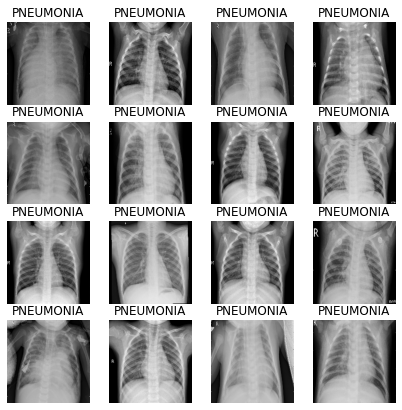

In [17]:
image_batch, label_batch = next(iter(D1['train']))
show_batch(image_batch.numpy(), label_batch.numpy())

#### [D2] 데이터셋 생성
- Augmentation으로 생성된 이미지를 추가
- 이미지의 크기 : 180x180 

In [79]:
filepaths_origin = filepaths['origin']['normal'] + filepaths['origin']['pneumonia']
print(f"{len(filepaths['origin']['normal'])} + {len(filepaths['origin']['pneumonia'])} = {len(filepaths_origin)}")

filepaths_aurgmentation = filepaths['aurgmentation']['normal'] + filepaths['aurgmentation']['pneumonia']
print(f"{len(filepaths['aurgmentation']['normal'])} + {len(filepaths['aurgmentation']['pneumonia'])} = {len(filepaths_aurgmentation)}")

filepathe_total = filepaths_origin + filepaths_aurgmentation
print(f"{len(filepaths_origin)} + {len(filepaths_aurgmentation)} = {len(filepathe_total)}")

1583 + 4273 = 5856
1583 + 4273 = 5856
5856 + 5856 = 11712


In [80]:
IMAGE_SIZE = [180, 180]
D2 = get_dataset(filepathe_total)
D2

{'train': <PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>,
 'test': <BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>,
 'val': <PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>,
 'TRAIN_IMG_COUNT': 8198,
 'VAL_IMG_COUNT': 1757,
 'TEST_IMG_COUNT': 1757}

- 데이터 확인

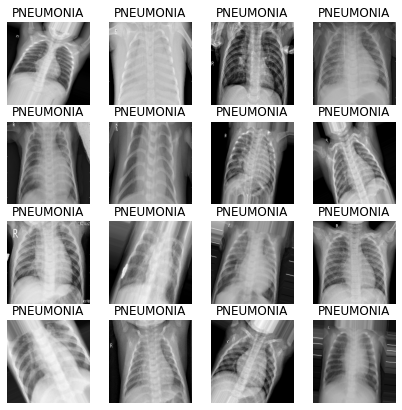

In [20]:
image_batch, label_batch = next(iter(D2['train']))
show_batch(image_batch.numpy(), label_batch.numpy())

#### [D3] 데이터셋 생성
- Augmentation으로 생성되지 않은 이미지로 구성
- 이지미의 크기 : 360x360

In [14]:
filepaths_origin = filepaths['origin']['normal'] + filepaths['origin']['pneumonia']
print(f"{len(filepaths['origin']['normal'])} + {len(filepaths['origin']['pneumonia'])} = {len(filepaths_origin)}")

1583 + 4273 = 5856


In [15]:
IMAGE_SIZE = [360, 360]
D3 = get_dataset(filepaths_origin)
D3

{'train': <PrefetchDataset shapes: ((None, 360, 360, 3), (None,)), types: (tf.float32, tf.bool)>,
 'test': <BatchDataset shapes: ((None, 360, 360, 3), (None,)), types: (tf.float32, tf.bool)>,
 'val': <PrefetchDataset shapes: ((None, 360, 360, 3), (None,)), types: (tf.float32, tf.bool)>,
 'TRAIN_IMG_COUNT': 4099,
 'VAL_IMG_COUNT': 879,
 'TEST_IMG_COUNT': 878}

- 데이터 확인

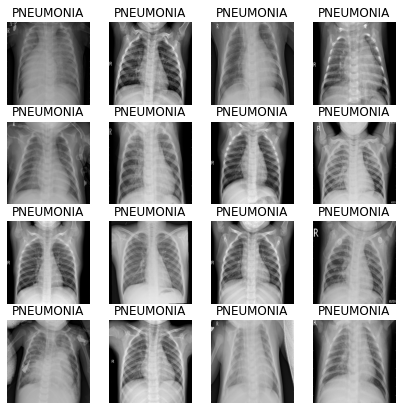

In [22]:
image_batch, label_batch = next(iter(D3['train']))
show_batch(image_batch.numpy(), label_batch.numpy())

## STEP 2. Modeling
---

### 1. Code Collection

- basic convolution

In [16]:
def conv_block(filters, kernel_size=3, activation='relu'):
    block = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters, kernel_size, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(filters, kernel_size, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

- Depthwise Convolution 

In [17]:
def depthwise_conv_block(filters, kernel_size=3, activation='relu'):
    block = tf.keras.Sequential([
        tf.keras.layers.DepthwiseConv2D(kernel_size, activation=activation, padding='same'),
        tf.keras.layers.DepthwiseConv2D(kernel_size, activation=activation, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

- Depthwise Separable Convolution

In [18]:
def depthwise_separable_conv_block(filters, kernel_size=3, activation='relu'):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, kernel_size, activation=activation, padding='same'),
        tf.keras.layers.SeparableConv2D(filters, kernel_size, activation=activation, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

- dense layer

In [19]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

- build model

In [20]:
def build_model(input_shape, conv_type='', kernel_size=3, activation='relu'):
    if conv_type == '':
        conv = conv_block
    elif conv_type == 'depthwise':
        conv = depthwise_conv_block
    elif conv_type == 'depthwise_separable':
        conv = depthwise_separable_conv_block
        
    model = tf.keras.Sequential([
        tf.keras.Input(shape=input_shape),
        
        tf.keras.layers.Conv2D(16, kernel_size, activation=activation, padding='same'),
        tf.keras.layers.Conv2D(16, kernel_size, activation=activation, padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv(32, kernel_size=kernel_size, activation=activation),
        conv(64, kernel_size=kernel_size, activation=activation),
        conv(128, kernel_size=kernel_size, activation=activation),
        tf.keras.layers.Dropout(0.2),
        
        conv(256, kernel_size=kernel_size, activation=activation),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

- get compiled model

In [21]:
def get_model(input_shape, conv_type='', kernel_size=3, activation='relu'):
    model = build_model(input_shape,
                        conv_type=conv_type,
                        kernel_size=kernel_size,
                        activation=activation)

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
    return model

- train model

In [22]:
@timer
def train_model(model, train_ds, steps_per_epoch, val_ds, validation_steps,
               epochs, class_weight, verbose=2):
    history = model.fit(train_ds,
                        steps_per_epoch=steps_per_epoch,
                        validation_data=val_ds,
                        validation_steps=validation_steps,
                        epochs=epochs,
                        class_weight=class_weight,
                        verbose=verbose)
    return history

- show history plot

In [23]:
def show_history_plot(history):
    fig, axs = plt.subplots(2,2, figsize=(10,7))
    axs = axs.ravel()
    keys = ['loss', 'accuracy', 'recall', 'precision']
    
    for i, key in enumerate(keys):
        axs[i].plot(history.history[key])
        axs[i].plot(history.history['val_' + key])
        axs[i].set_title(key.upper())
        axs[i].set_xlabel('epochs')
        axs[i].set_ylabel(key)
        axs[i].legend(['train', 'val'])
    plt.tight_layout()
    plt.show()

### 2. Convolutaion Layer에 다른 성능차이 확인

- 하이퍼 파라미터 정의

In [44]:
# class_weight
COUNT_NORMAL = len(filepaths['origin']['normal'])
COUNT_PNEUMONIA = len(filepaths['origin']['pneumonia'])
TRAIN_IMG_COUNT = D1['TRAIN_IMG_COUNT']

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}
print(f'class_weight : {class_weight}')

epochs = 25

class_weight : {0: 1.2946936197094123, 1: 0.47963959747250173}


#### 1. Basic Convolution Layer

- 모델 정의

In [45]:
conv_model = get_model((180, 180, 3))
conv_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
sequential (Sequential)      (None, 45, 45, 32)        14016     
_________________________________________________________________
sequential_1 (Sequential)    (None, 22, 22, 64)        55680     
_________________________________________________________________
sequential_2 (Sequential)    (None, 11, 11, 128)       221952    
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 128)      

- 모델 학습

In [50]:
conv_history, conv_train_time = train_model(conv_model,
                                            D1['train'],
                                            D1['TRAIN_IMG_COUNT'] // BATCH_SIZE,
                                            D1['val'],
                                            D1['VAL_IMG_COUNT'] // BATCH_SIZE,
                                            epochs,
                                            class_weight)

Epoch 1/25
256/256 - 31s - loss: 0.2028 - accuracy: 0.8904 - precision: 0.9589 - recall: 0.8881 - val_loss: 0.6192 - val_accuracy: 0.7326 - val_precision: 0.7326 - val_recall: 1.0000
Epoch 2/25
256/256 - 25s - loss: 0.1780 - accuracy: 0.9065 - precision: 0.9637 - recall: 0.9061 - val_loss: 0.4139 - val_accuracy: 0.8206 - val_precision: 0.8048 - val_recall: 0.9968
Epoch 3/25
256/256 - 25s - loss: 0.1864 - accuracy: 0.9001 - precision: 0.9594 - recall: 0.9014 - val_loss: 1.1816 - val_accuracy: 0.7315 - val_precision: 0.7315 - val_recall: 1.0000
Epoch 4/25
256/256 - 25s - loss: 0.1561 - accuracy: 0.9155 - precision: 0.9695 - recall: 0.9133 - val_loss: 0.2343 - val_accuracy: 0.9005 - val_precision: 0.8974 - val_recall: 0.9764
Epoch 5/25
256/256 - 25s - loss: 0.1715 - accuracy: 0.9070 - precision: 0.9605 - recall: 0.9101 - val_loss: 0.1930 - val_accuracy: 0.9236 - val_precision: 0.9249 - val_recall: 0.9747
Epoch 6/25
256/256 - 26s - loss: 0.1402 - accuracy: 0.9204 - precision: 0.9713 - reca

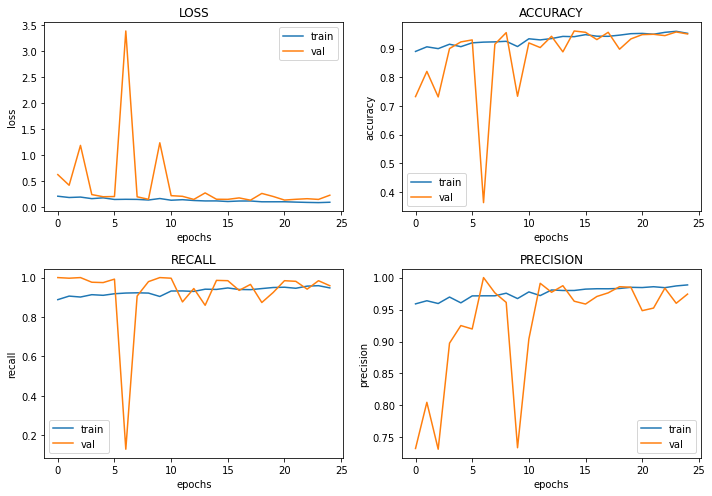

In [74]:
show_history_plot(conv_history)

- 모델평가

In [83]:
conv_test_loss, conv_test_acc, conv_test_prec, conv_test_recall = conv_model.evaluate(D1['test'])

55/55 [==============================] - 4s 69ms/step - loss: 0.1885 - accuracy: 0.9567 - precision: 0.9761 - recall: 0.9638


#### 2. Depthwise Convolutiton Layer

- 모델 정의

In [86]:
depth_model = get_model((180, 180, 3), conv_type='depthwise')
depth_model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
sequential_24 (Sequential)   (None, 45, 45, 16)        384       
_________________________________________________________________
sequential_25 (Sequential)   (None, 22, 22, 16)        384       
_________________________________________________________________
sequential_26 (Sequential)   (None, 11, 11, 16)        384       
_________________________________________________________________
dropout_15 (Dropout)         (None, 11, 11, 16)      

- 모델 학습

In [87]:
depth_history, depth_train_time = train_model(depth_model,
                                            D1['train'],
                                            D1['TRAIN_IMG_COUNT'] // BATCH_SIZE,
                                            D1['val'],
                                            D1['VAL_IMG_COUNT'] // BATCH_SIZE,
                                            epochs,
                                            class_weight)

Epoch 1/25
256/256 - 34s - loss: 0.4965 - accuracy: 0.6184 - precision: 0.8322 - recall: 0.5984 - val_loss: 0.6164 - val_accuracy: 0.7350 - val_precision: 0.7350 - val_recall: 1.0000
Epoch 2/25
256/256 - 27s - loss: 0.3572 - accuracy: 0.7539 - precision: 0.9106 - recall: 0.7354 - val_loss: 1.0011 - val_accuracy: 0.7326 - val_precision: 0.7326 - val_recall: 1.0000
Epoch 3/25
256/256 - 26s - loss: 0.2981 - accuracy: 0.8015 - precision: 0.9353 - recall: 0.7823 - val_loss: 0.3012 - val_accuracy: 0.8588 - val_precision: 0.8808 - val_recall: 0.9336
Epoch 4/25
256/256 - 26s - loss: 0.2572 - accuracy: 0.8359 - precision: 0.9528 - recall: 0.8160 - val_loss: 0.3390 - val_accuracy: 0.8438 - val_precision: 0.8476 - val_recall: 0.9589
Epoch 5/25
256/256 - 26s - loss: 0.2301 - accuracy: 0.8547 - precision: 0.9565 - recall: 0.8391 - val_loss: 0.3765 - val_accuracy: 0.8403 - val_precision: 0.9902 - val_recall: 0.7909
Epoch 6/25
256/256 - 27s - loss: 0.2357 - accuracy: 0.8506 - precision: 0.9539 - reca

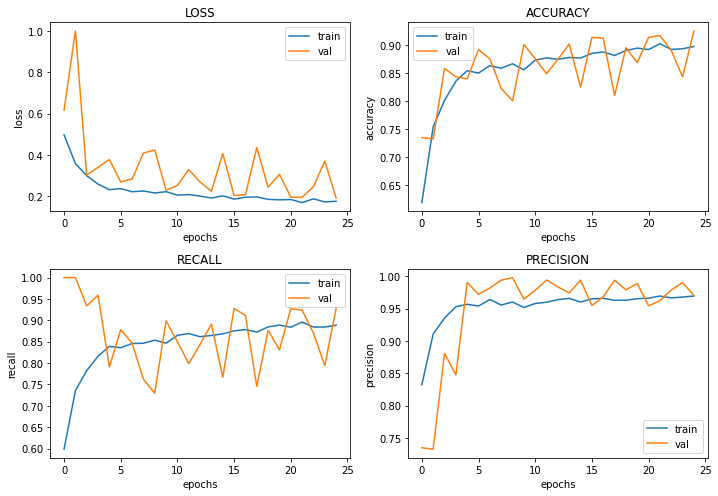

In [88]:
show_history_plot(depth_history)

- 모델 평가

In [89]:
depth_test_loss, depth_test_acc, depth_test_prec, depth_test_recall = depth_model.evaluate(D1['test'])

55/55 [==============================] - 4s 61ms/step - loss: 0.1743 - accuracy: 0.9260 - precision: 0.9750 - recall: 0.9213


#### 3. Depthwise Separable Convolution Layer

In [90]:
depth_sep_model = get_model((180, 180, 3), conv_type='depthwise_separable')
depth_sep_model.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
sequential_32 (Sequential)   (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_33 (Sequential)   (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_34 (Sequential)   (None, 11, 11, 128)       27072     
_________________________________________________________________
dropout_20 (Dropout)         (None, 11, 11, 128)     

- 모델 학습

In [91]:
depth_sep_history, depth_sep_train_time = train_model(depth_sep_model,
                                            D1['train'],
                                            D1['TRAIN_IMG_COUNT'] // BATCH_SIZE,
                                            D1['val'],
                                            D1['VAL_IMG_COUNT'] // BATCH_SIZE,
                                            epochs,
                                            class_weight)

Epoch 1/25
256/256 - 34s - loss: 0.3109 - accuracy: 0.7996 - precision: 0.9393 - recall: 0.7758 - val_loss: 0.6140 - val_accuracy: 0.7292 - val_precision: 0.7292 - val_recall: 1.0000
Epoch 2/25
256/256 - 26s - loss: 0.2247 - accuracy: 0.8750 - precision: 0.9572 - recall: 0.8677 - val_loss: 0.7326 - val_accuracy: 0.7326 - val_precision: 0.7326 - val_recall: 1.0000
Epoch 3/25
256/256 - 26s - loss: 0.1864 - accuracy: 0.8943 - precision: 0.9645 - recall: 0.8881 - val_loss: 0.1712 - val_accuracy: 0.9352 - val_precision: 0.9406 - val_recall: 0.9732
Epoch 4/25
256/256 - 27s - loss: 0.1797 - accuracy: 0.9031 - precision: 0.9652 - recall: 0.8997 - val_loss: 0.1668 - val_accuracy: 0.9340 - val_precision: 0.9646 - val_recall: 0.9449
Epoch 5/25
256/256 - 27s - loss: 0.1405 - accuracy: 0.9211 - precision: 0.9717 - recall: 0.9187 - val_loss: 0.2365 - val_accuracy: 0.8831 - val_precision: 0.8648 - val_recall: 0.9952
Epoch 6/25
256/256 - 27s - loss: 0.1399 - accuracy: 0.9214 - precision: 0.9728 - reca

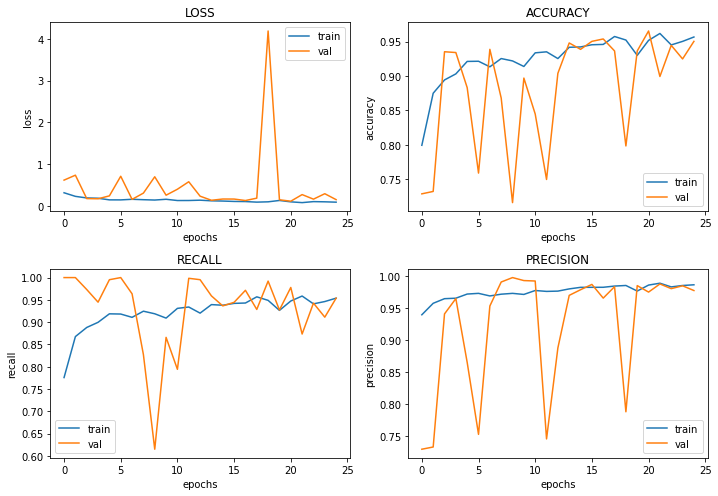

In [92]:
show_history_plot(depth_sep_history)

- 모델 평가

In [94]:
depth_sep_test_loss, depth_sep_test_acc, depth_sep_test_prec, depth_sep_test_recall = depth_sep_model.evaluate(D1['test'])

55/55 [==============================] - 4s 66ms/step - loss: 0.1219 - accuracy: 0.9567 - precision: 0.9761 - recall: 0.9638


#### 4. 지표 비교

In [138]:
metrix = {
    'conv' : {
        'recall' : conv_test_recall,
        'accuracy' : conv_test_acc,
        'loss' : conv_test_loss, 
        'train time': conv_train_time,
        'total params' : 4534801
    },
    'depthwise' : {
        'recall' : depth_test_recall,
        'accuracy' : depth_test_acc,
        'loss' : depth_test_loss, 
        'train time': depth_train_time,
        'total params' : 286417
    },
    'depthwise separable': {
        'recall' : depth_sep_test_recall,
        'accuracy' : depth_sep_test_acc,
        'loss' : depth_sep_test_loss, 
        'train time': depth_sep_train_time,
        'total params' : 3496801
    }
}
metrix

{'conv': {'recall': 0.9637795090675354,
  'accuracy': 0.9567198157310486,
  'loss': 0.18848378956317902,
  'train time': 602.5338383500002,
  'total params': 4534801},
 'depthwise': {'recall': 0.9212598204612732,
  'accuracy': 0.9259681105613708,
  'loss': 0.174287348985672,
  'train time': 623.9457605309999,
  'total params': 286417},
 'depthwise separable': {'recall': 0.9637795090675354,
  'accuracy': 0.9567198157310486,
  'loss': 0.12189379334449768,
  'train time': 632.4590176199999,
  'total params': 3496801}}

In [98]:
pd.options.display.float_format = '{:.4f}'.format
metrix_df = pd.DataFrame(metrix)
metrix_df

,conv,depthwise,depthwise separable
recall,0.9638,0.9213,0.9638
accuracy,0.9567,0.9260,0.9567
loss,0.1885,0.1743,0.1219
train time,602.5338,623.9458,632.4590
total params,4534801.0000,286417.0000,3496801.0000


/home/aiffel-dj1/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


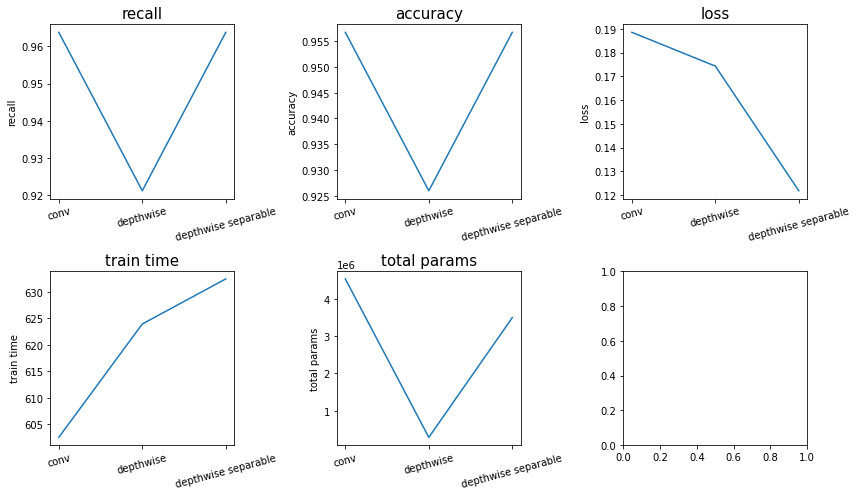

In [137]:
fig, axs = plt.subplots(2, 3, figsize=(12, 7))
axs = axs.ravel()

for i, idx in enumerate(metrix_df.index):
    axs[i].plot(metrix_df.loc[idx])
    axs[i].set_title(idx, fontsize=15)
    axs[i].set_ylabel(idx)
    axs[i].set_xticklabels(labels=list(metrix_df.columns), rotation=15)
plt.tight_layout()
plt.show()

- 기본 convolution layar(이하 conv)를 사용한 모델과 depthwise convolution laeyr(이하 depth-sep)를 사용한 모델의 accuary와 reacll가 동일하게 나타났다.
- loss의 값은 dept-sep에서 가장 낮게 관측되었다.
- 모델을 학습시키는 것에 걸리는 시간은 conv > depthwise > depth-sep 순으로 오래 걸렸다.
- 모델의 파라미터 수는 conv > depth-seq > depth 순으로 적었다.
- 해당 지표들을 토대로 depth-sep가 가장 좋은 성능을 보인다고 할 수 있다.
- 다만 문제가 될 수 있는 부분은 depth-sep의 train history를 나타낸 그래프를 보면, 그래프의 양상이 상당히 불안정한 모습을 보인다. 그래서 이것이 혹시 폐렴이 아닌 데이터들에 대하여 학습이 이루어지지 않은 것은 아닐까 하는 의문이 모락모락 피어올랐다.

### 3. BatchNormalization과 Dropout에 따른 성능차이 확인

- 함수 재정의 : 실험을 위하여 BarchNorm/Drop layer의 포함 여부를 파라미터 값으로 조절할 수 있도록 build model 함수를 재정의 한다.

In [24]:
def depthwise_separable_conv_block_v2(filters, kernel_size=3, activation='relu', contain_batchnorm=True):
    block = tf.keras.Sequential()
    block.add(tf.keras.layers.SeparableConv2D(filters, kernel_size, activation=activation, padding='same'))
    block.add(tf.keras.layers.SeparableConv2D(filters, kernel_size, activation=activation, padding='same'))
    if contain_batchnorm:
        block.add(tf.keras.layers.BatchNormalization())
    block.add(tf.keras.layers.MaxPool2D())

    return block

In [25]:
def dense_block_v2(units, dropout_rate, contain_batchnorm=True, contain_dropout=True):
    block = tf.keras.Sequential()
    block.add(tf.keras.layers.Dense(units, activation='relu'))
    if contain_batchnorm:
        block.add(tf.keras.layers.BatchNormalization())
    if contain_dropout:
        block.add(tf.keras.layers.Dropout(dropout_rate))
    
    return block

In [26]:
def build_model_v2(input_shape, kernel_size=3, activation='relu', contain_batchnorm=True, contain_dropout=True):
    conv = depthwise_separable_conv_block_v2

    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=input_shape))
    model.add(tf.keras.layers.Conv2D(16, kernel_size, activation=activation, padding='same'))
    model.add(tf.keras.layers.Conv2D(16, kernel_size, activation=activation, padding='same'))
    model.add(tf.keras.layers.MaxPool2D())
        
    model.add(conv(32, kernel_size=kernel_size, activation=activation, contain_batchnorm=contain_batchnorm))
    model.add(conv(64, kernel_size=kernel_size, activation=activation, contain_batchnorm=contain_batchnorm))
    model.add(conv(128, kernel_size=kernel_size, activation=activation, contain_batchnorm=contain_batchnorm))
    if contain_dropout:
        model.add(tf.keras.layers.Dropout(0.2))
        
    model.add(conv(256, kernel_size=kernel_size, activation=activation, contain_batchnorm=contain_batchnorm))
    if contain_dropout:
        model.add(tf.keras.layers.Dropout(0.2))
        
    model.add(tf.keras.layers.Flatten())
    model.add(dense_block_v2(512, 0.7, contain_batchnorm=contain_batchnorm, contain_dropout=contain_dropout))
    model.add(dense_block_v2(128, 0.5, contain_batchnorm=contain_batchnorm, contain_dropout=contain_dropout))
    model.add(dense_block_v2(64, 0.3, contain_batchnorm=contain_batchnorm, contain_dropout=contain_dropout))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    return model

In [27]:
def get_model_v2(input_shape, kernel_size=3, activation='relu', contain_batchnorm=True, contain_dropout=True):
    model = build_model_v2(input_shape,
                           kernel_size=kernel_size,
                           activation=activation,
                           contain_batchnorm=contain_batchnorm,
                           contain_dropout=contain_dropout)

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
    return model

- 하이퍼 파라미터 정의

In [174]:
# class_weight
COUNT_NORMAL = len(filepaths['origin']['normal'])
COUNT_PNEUMONIA = len(filepaths['origin']['pneumonia'])
TRAIN_IMG_COUNT = D1['TRAIN_IMG_COUNT']

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}
print(f'class_weight : {class_weight}')

epochs = 25

class_weight : {0: 1.2946936197094123, 1: 0.47963959747250173}


#### 1. BatchNormalization과 Dropout을 모두 제거한 모델 - remove_bd
- 모델정의

In [173]:
remove_bd_model = get_model_v2((180, 180, 3), 
                               contain_batchnorm=False,
                               contain_dropout=False)
remove_bd_model.summary()

Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
sequential_70 (Sequential)   (None, 45, 45, 32)        2032      
_________________________________________________________________
sequential_71 (Sequential)   (None, 22, 22, 64)        7136      
_________________________________________________________________
sequential_72 (Sequential)   (None, 11, 11, 128)       26560     
_________________________________________________________________
sequential_73 (Sequential)   (None, 5, 5, 256)       

- 모델 학습

In [175]:
remove_bd_history, remove_bd_train_time = train_model(remove_bd_model,
                                                      D1['train'],
                                                      D1['TRAIN_IMG_COUNT'] // BATCH_SIZE,
                                                      D1['val'],
                                                      D1['VAL_IMG_COUNT'] // BATCH_SIZE,
                                                      epochs,
                                                      class_weight)

Epoch 1/25
256/256 - 30s - loss: 0.4845 - accuracy: 0.6230 - precision: 0.7324 - recall: 0.7632 - val_loss: 0.6889 - val_accuracy: 0.7292 - val_precision: 0.7292 - val_recall: 1.0000
Epoch 2/25
256/256 - 24s - loss: 0.4852 - accuracy: 0.6606 - precision: 0.7283 - recall: 0.8535 - val_loss: 0.6951 - val_accuracy: 0.2697 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
256/256 - 24s - loss: 0.4844 - accuracy: 0.2717 - precision: 0.6250 - recall: 0.0100 - val_loss: 0.6931 - val_accuracy: 0.7338 - val_precision: 0.7338 - val_recall: 1.0000
Epoch 4/25
256/256 - 24s - loss: 0.4851 - accuracy: 0.5620 - precision: 0.7265 - recall: 0.6415 - val_loss: 0.6921 - val_accuracy: 0.7338 - val_precision: 0.7338 - val_recall: 1.0000
Epoch 5/25
256/256 - 24s - loss: 0.4846 - accuracy: 0.4565 - precision: 0.7162 - recall: 0.4248 - val_loss: 0.6936 - val_accuracy: 0.2685 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 6/25
256/256 - 25s - loss: 0.4846 - accuracy: 0.6047 - precisio

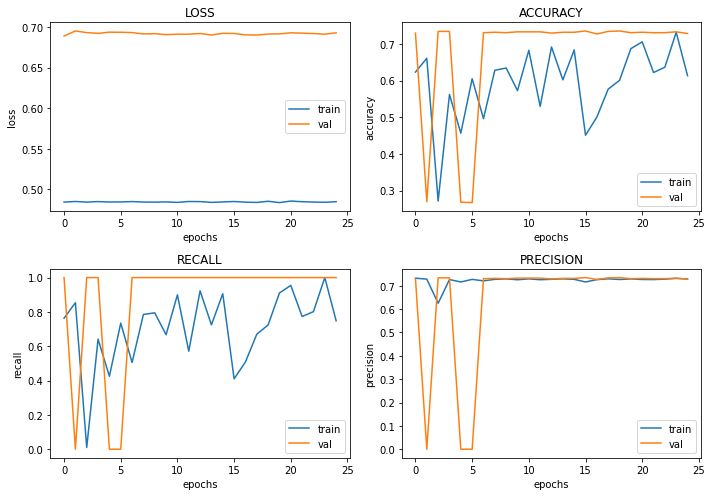

In [177]:
show_history_plot(remove_bd_history)

- 모델 평가

In [178]:
remove_bd_test_loss, remove_bd_test_acc, remove_bd_test_prec, remove_bd_test_recall = remove_bd_model.evaluate(D1['test'])

55/55 [==============================] - 3s 57ms/step - loss: 0.6928 - accuracy: 0.7232 - precision: 0.7232 - recall: 1.0000


#### 2. BatchNormalization을 제거한 모델 - remove_b
- 모델 정의

In [179]:
remove_b_model = get_model_v2((180, 180, 3), 
                               contain_batchnorm=False,
                               contain_dropout=True)
remove_b_model.summary()

Model: "sequential_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
sequential_78 (Sequential)   (None, 45, 45, 32)        2032      
_________________________________________________________________
sequential_79 (Sequential)   (None, 22, 22, 64)        7136      
_________________________________________________________________
sequential_80 (Sequential)   (None, 11, 11, 128)       26560     
_________________________________________________________________
dropout_25 (Dropout)         (None, 11, 11, 128)     

- 모델 학습

In [180]:
remove_b_history, remove_b_train_time = train_model(remove_b_model,
                                                    D1['train'],
                                                    D1['TRAIN_IMG_COUNT'] // BATCH_SIZE,
                                                    D1['val'],
                                                    D1['VAL_IMG_COUNT'] // BATCH_SIZE,
                                                    epochs,
                                                    class_weight)

Epoch 1/25
256/256 - 30s - loss: 0.4853 - accuracy: 0.5264 - precision: 0.7270 - recall: 0.5633 - val_loss: 0.7000 - val_accuracy: 0.2650 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
256/256 - 23s - loss: 0.4849 - accuracy: 0.5442 - precision: 0.7215 - recall: 0.6128 - val_loss: 0.6951 - val_accuracy: 0.2674 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
256/256 - 24s - loss: 0.4848 - accuracy: 0.5071 - precision: 0.7355 - recall: 0.5082 - val_loss: 0.6954 - val_accuracy: 0.2708 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
256/256 - 24s - loss: 0.4844 - accuracy: 0.5583 - precision: 0.7356 - recall: 0.6179 - val_loss: 0.6832 - val_accuracy: 0.7326 - val_precision: 0.7326 - val_recall: 1.0000
Epoch 5/25
256/256 - 24s - loss: 0.4858 - accuracy: 0.5369 - precision: 0.7256 - recall: 0.5875 - val_loss: 0.7059 - val_accuracy: 0.2708 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 6/25
256/256 - 24s - loss: 0.4847 - accuracy: 0

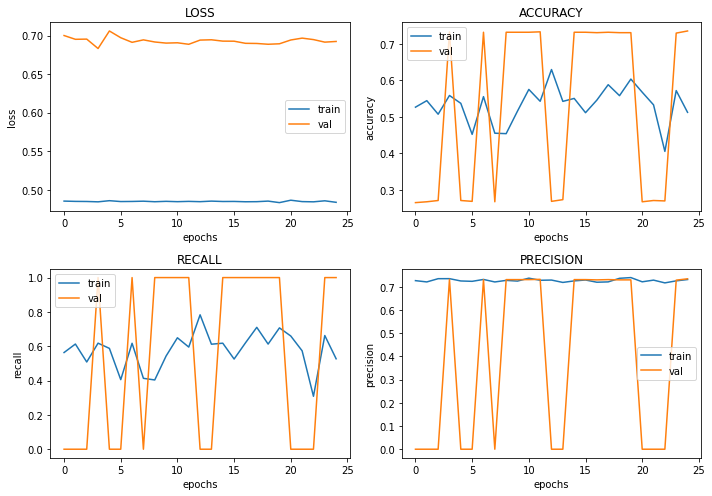

In [181]:
show_history_plot(remove_b_history)

- 모델 평가

In [183]:
remove_b_test_loss, remove_b_test_acc, remove_b_test_prec, remove_b_test_recall = remove_b_model.evaluate(D1['test'])

55/55 [==============================] - 3s 57ms/step - loss: 0.6924 - accuracy: 0.7232 - precision: 0.7232 - recall: 1.0000


#### 3. Dropout을 제거한 모델 - remove_d
- 모델 정의

In [184]:
remove_d_model = get_model_v2((180, 180, 3), 
                               contain_batchnorm=True,
                               contain_dropout=False)
remove_d_model.summary()

Model: "sequential_85"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
sequential_86 (Sequential)   (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_87 (Sequential)   (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_88 (Sequential)   (None, 11, 11, 128)       27072     
_________________________________________________________________
sequential_89 (Sequential)   (None, 5, 5, 256)       

- 모델 학습

In [185]:
remove_d_history, remove_d_train_time = train_model(remove_d_model,
                                                    D1['train'],
                                                    D1['TRAIN_IMG_COUNT'] // BATCH_SIZE,
                                                    D1['val'],
                                                    D1['VAL_IMG_COUNT'] // BATCH_SIZE,
                                                    epochs,
                                                    class_weight)

Epoch 1/25
256/256 - 31s - loss: 0.1970 - accuracy: 0.8855 - precision: 0.9640 - recall: 0.8760 - val_loss: 0.5922 - val_accuracy: 0.7315 - val_precision: 0.7315 - val_recall: 1.0000
Epoch 2/25
256/256 - 23s - loss: 0.1455 - accuracy: 0.9221 - precision: 0.9708 - recall: 0.9212 - val_loss: 0.7945 - val_accuracy: 0.7303 - val_precision: 0.7303 - val_recall: 1.0000
Epoch 3/25
256/256 - 23s - loss: 0.1317 - accuracy: 0.9294 - precision: 0.9737 - recall: 0.9285 - val_loss: 0.6589 - val_accuracy: 0.7384 - val_precision: 0.9951 - val_recall: 0.6467
Epoch 4/25
256/256 - 24s - loss: 0.1203 - accuracy: 0.9375 - precision: 0.9763 - recall: 0.9372 - val_loss: 0.2880 - val_accuracy: 0.8681 - val_precision: 0.8505 - val_recall: 0.9937
Epoch 5/25
256/256 - 24s - loss: 0.0981 - accuracy: 0.9458 - precision: 0.9809 - recall: 0.9442 - val_loss: 0.1464 - val_accuracy: 0.9479 - val_precision: 0.9426 - val_recall: 0.9889
Epoch 6/25
256/256 - 24s - loss: 0.0930 - accuracy: 0.9504 - precision: 0.9804 - reca

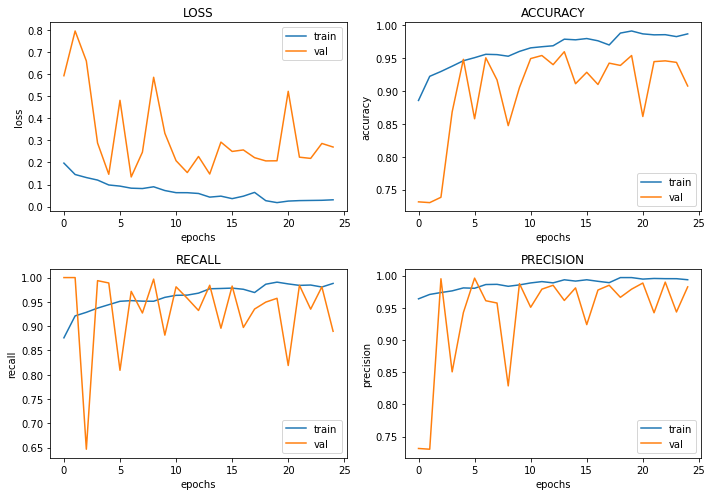

In [186]:
show_history_plot(remove_d_history)

- 모델 평가

In [187]:
remove_d_test_loss, remove_d_test_acc, remove_d_test_prec, remove_d_test_recall = remove_d_model.evaluate(D1['test'])

55/55 [==============================] - 3s 57ms/step - loss: 0.3399 - accuracy: 0.8827 - precision: 0.9836 - recall: 0.8520


#### 4. 지표 비교

In [188]:
metrix_bd = {
    'remove nothing': {
        'recall' : depth_sep_test_recall,
        'accuracy' : depth_sep_test_acc,
        'loss' : depth_sep_test_loss, 
        'train time': depth_sep_train_time,
        'total params' : 3496801
    },
    'remove_bd': {
        'recall' : remove_bd_test_recall,
        'accuracy' : remove_bd_test_acc,
        'loss' : remove_bd_test_loss, 
        'train time': remove_bd_train_time,
        'total params' : 3492065
    },
    'remove_b': {
        'recall' : remove_b_test_recall,
        'accuracy' : remove_b_test_acc,
        'loss' : remove_b_test_loss, 
        'train time': remove_b_train_time,
        'total params' : 3492065
    },
    'remove_d': {
        'recall' : remove_d_test_recall,
        'accuracy' : remove_d_test_acc,
        'loss' : remove_d_test_loss, 
        'train time': remove_d_train_time,
        'total params' : 3496801
    }
}
metrix_bd

{'remove nothing': {'recall': 0.9637795090675354,
  'accuracy': 0.9567198157310486,
  'loss': 0.12189379334449768,
  'train time': 632.4590176199999,
  'total params': 3496801},
 'remove_bd': {'recall': 1.0,
  'accuracy': 0.7232346534729004,
  'loss': 0.6927865743637085,
  'train time': 587.0004051389988,
  'total params': 3492065},
 'remove_b': {'recall': 1.0,
  'accuracy': 0.7232346534729004,
  'loss': 0.6923882961273193,
  'train time': 587.3833958779978,
  'total params': 3492065},
 'remove_d': {'recall': 0.85196852684021,
  'accuracy': 0.8826879262924194,
  'loss': 0.3399050533771515,
  'train time': 580.8770748989991,
  'total params': 3496801}}

In [189]:
pd.options.display.float_format = '{:.4f}'.format
metrix_bd_df = pd.DataFrame(metrix_bd)
metrix_bd_df

,remove nothing,remove_bd,remove_b,remove_d
recall,0.9638,1.0000,1.0000,0.8520
accuracy,0.9567,0.7232,0.7232,0.8827
loss,0.1219,0.6928,0.6924,0.3399
train time,632.4590,587.0004,587.3834,580.8771
total params,3496801.0000,3492065.0000,3492065.0000,3496801.0000


/home/aiffel-dj1/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


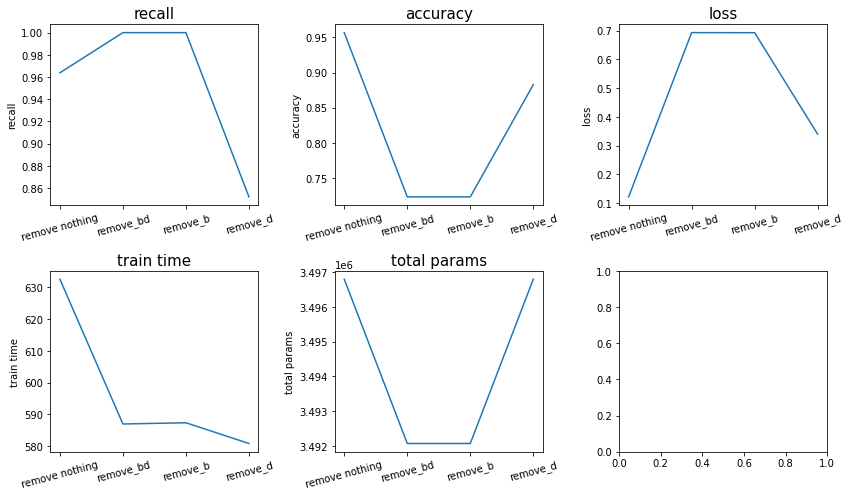

In [193]:
fig, axs = plt.subplots(2, 3, figsize=(12, 7))
axs = axs.ravel()

for i, idx in enumerate(metrix_bd_df.index):
    axs[i].plot(metrix_bd_df.loc[idx])
    axs[i].set_title(idx, fontsize=15)
    axs[i].set_ylabel(idx)
    axs[i].set_xticklabels(labels=list(metrix_bd_df.columns), rotation=15)
plt.tight_layout()
plt.show()

- BatchNormalization을 제거한 remove_bd, remove_b의 경우, BatchNormalization이 존재하는 다른 모델에 비하여 acccuray가 현저히 낮고 loss가 매우 높은 것을 볼 수 있었다. 또한 recall이 1인데, 이는 학습이 잘못되었다는 것을 시사하고 있다.
- Dropout을 제거한 remove_bd, remove_d의 경우에는 remove nothing 모델과 비교하면 지표 값들이 악화되기는 하였으나, 그 정도가 BatchNormalization을 제거하였을 때 보다 덜하다는 것을 알 수 있었다.
- 지표와 train history을 토대로 생각해보면, 실험에 참가한 세 모델 모두 제대로 학습되었다고 보기 힘들며, 아무것고 제거하지 않은 모델을 가장 좋은 성능을 보였다.

### 4. 하이퍼 파라미터에 따른 성능차이 확인
두 가지 하이퍼 파라미터 kernel size, class weight 따른 학습 결과 차이를 확인해 본다.

#### 1. 실험 변수 정의
실험에 사용될 하이퍼 파라미터의 값을 선정한다.

- kernel size

In [212]:
kernel_size = [7, 5, 3]

- class weight

In [198]:
class_weight = []
class_weight.append({0 : 1, 1 : 1 })
class_weight.append({0 : 2, 1 : 1 })
class_weight.append({0 : 1, 1 : 2 })
class_weight

[{0: 1.2946936197094123, 1: 0.47963959747250173},
 {0: 1, 1: 1},
 {0: 2, 1: 1},
 {0: 1, 1: 2}]

- base

In [203]:
base = {
        'kernel_size' : 3,
        'class_weight' : class_weight[0],
        'epochs' : 25
       }

#### 2. kernel에 따른 성능변화

[🔥 hyper parmas test] kernel_size : 7

Model: "sequential_133"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 180, 180, 16)      2368      
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 180, 180, 16)      12560     
_________________________________________________________________
max_pooling2d_93 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
sequential_134 (Sequential)  (None, 45, 45, 32)        4080      
_________________________________________________________________
sequential_135 (Sequential)  (None, 22, 22, 64)        11232     
_________________________________________________________________
sequential_136 (Sequential)  (None, 11, 11, 128)       34752     
_________________________________________________________________
dropout_55 (D

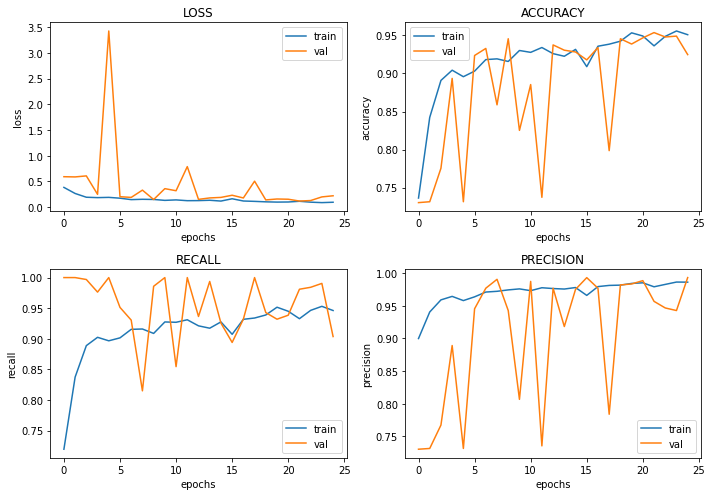

55/55 [==============================] - 4s 61ms/step - loss: 0.2264 - accuracy: 0.9134 - precision: 0.9895 - recall: 0.8898



[🔥 hyper parmas test] kernel_size : 5

Model: "sequential_141"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 180, 180, 16)      1216      
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 180, 180, 16)      6416      
_________________________________________________________________
max_pooling2d_98 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
sequential_142 (Sequential)  (None, 45, 45, 32)        2928      
_________________________________________________________________
sequential_143 (Sequential)  (None, 22, 22, 64)        8928      
_________________________________________________________________
sequential_144 (S

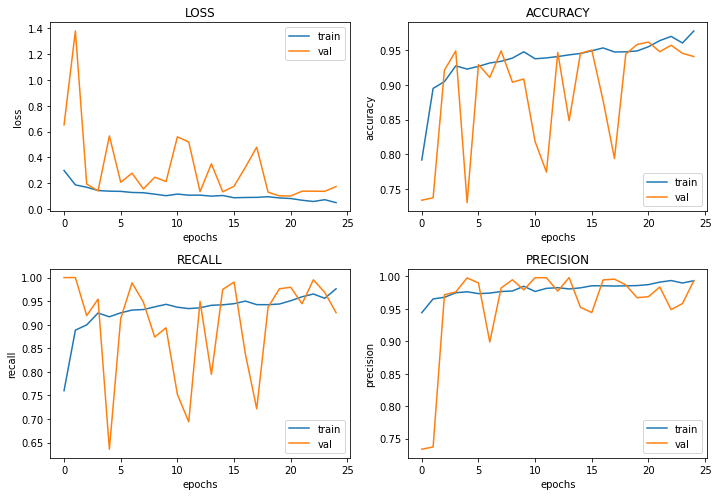

55/55 [==============================] - 3s 58ms/step - loss: 0.2144 - accuracy: 0.9317 - precision: 0.9931 - recall: 0.9118



[🔥 hyper parmas test] kernel_size : 3

Model: "sequential_149"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d_103 (MaxPoolin (None, 90, 90, 16)        0         
_________________________________________________________________
sequential_150 (Sequential)  (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_151 (Sequential)  (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_152 (S

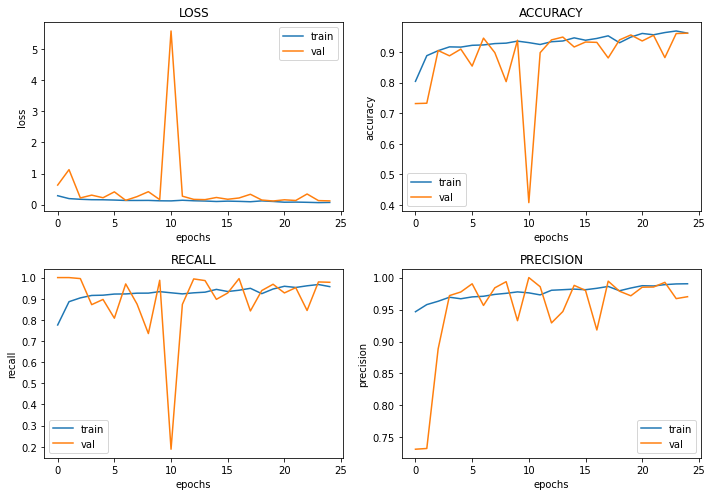

55/55 [==============================] - 3s 52ms/step - loss: 0.1462 - accuracy: 0.9556 - precision: 0.9715 - recall: 0.9669





In [215]:
metrix_d = {}

for k in kernel_size:
    print(f'[🔥 hyper parmas test] kernel_size : {k}\n')
    k_model = get_model_v2((180, 180, 3), kernel_size=k)
    k_model.summary()
    history, train_time = train_model(k_model,
                                      D1['train'],
                                      D1['TRAIN_IMG_COUNT'] // BATCH_SIZE,
                                      D1['val'],
                                      D1['VAL_IMG_COUNT'] // BATCH_SIZE,
                                      base['epochs'],
                                      base['class_weight'],
                                      verbose=0)
    show_history_plot(history)
    test_loss, test_acc, test_prec, test_recall = k_model.evaluate(D1['test'])
    
    metrix_d[k] = {
        'recall' : test_recall,
        'accuracy' : test_acc,
        'loss' : test_loss, 
        'train time': train_time,
        'total params' : -1
    }
    print('\n\n')

In [234]:
metrix_k={
    '7':{
        'recall' : 0.8898,
        'accuracy' : 0.9134,
        'loss' : 0.2264
    },
    '5':{
        'recall' : 0.9118,
        'accuracy' : 0.9317,
        'loss' : 0.2144
    },
    '3': {
        'recall' : 0.9669,
        'accuracy' : 0.9556,
        'loss' : 0.1462 
    }
}

In [235]:
metrix_k_df = pd.DataFrame(metrix_k)
metrix_k_df

,7,5,3
recall,0.8898,0.9118,0.9669
accuracy,0.9134,0.9317,0.9556
loss,0.2264,0.2144,0.1462


/home/aiffel-dj1/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


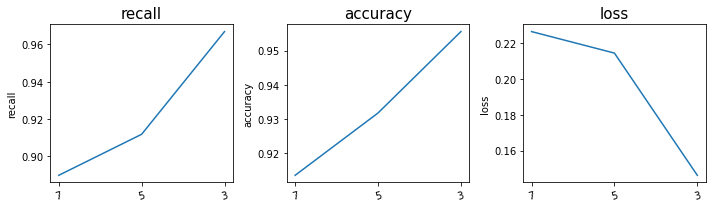

In [240]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
axs = axs.ravel()

for i, idx in enumerate(metrix_k_df.index):
    axs[i].plot(metrix_k_df.loc[idx])
    axs[i].set_title(idx, fontsize=15)
    axs[i].set_ylabel(idx)
    axs[i].set_xticklabels(labels=list(metrix_k_df.columns), rotation=15)
plt.tight_layout()
plt.show()

커널의 크기가 작아질 수록 더 좋은 성능을 보였다.

#### 3. class_weight에 따른 성능변화

[🔥 hyper parmas test] class_weight : {0: 1.2946936197094123, 1: 0.47963959747250173}

Model: "sequential_157"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_52 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d_108 (MaxPoolin (None, 90, 90, 16)        0         
_________________________________________________________________
sequential_158 (Sequential)  (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_159 (Sequential)  (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_160 (Sequential)  (None, 11, 11, 128)       27072     
________________________________

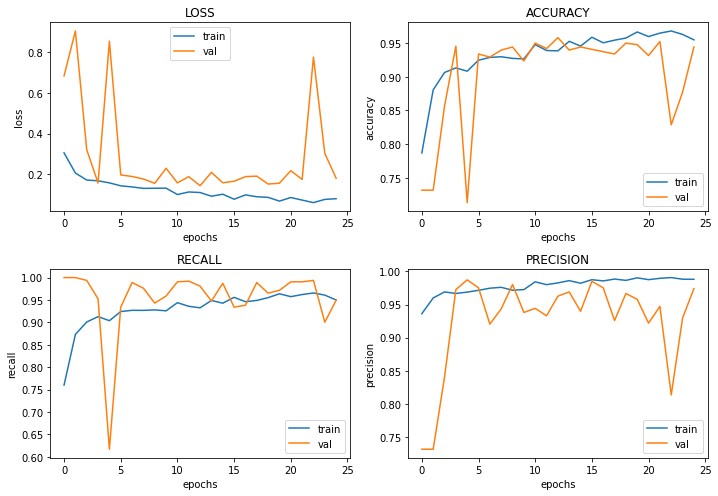

55/55 [==============================] - 3s 57ms/step - loss: 0.1866 - accuracy: 0.9317 - precision: 0.9768 - recall: 0.9276



[🔥 hyper parmas test] class_weight : {0: 1, 1: 1}

Model: "sequential_165"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d_113 (MaxPoolin (None, 90, 90, 16)        0         
_________________________________________________________________
sequential_166 (Sequential)  (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_167 (Sequential)  (None, 22, 22, 64)        7392      
_________________________________________________________________
seque

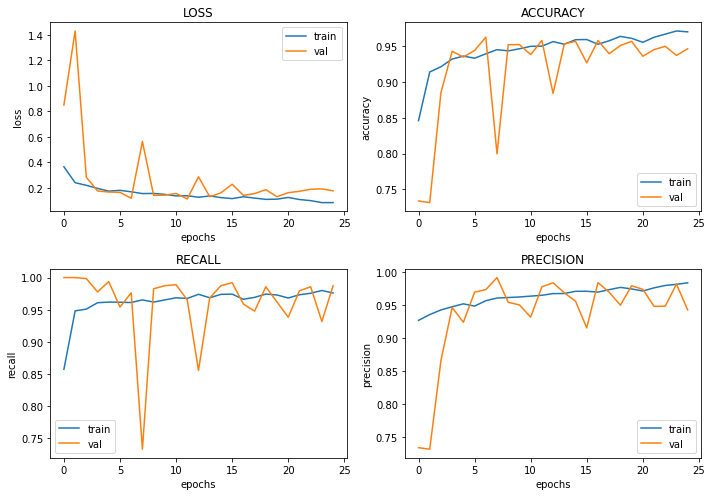

55/55 [==============================] - 3s 57ms/step - loss: 0.1459 - accuracy: 0.9624 - precision: 0.9645 - recall: 0.9843



[🔥 hyper parmas test] class_weight : {0: 2, 1: 1}

Model: "sequential_173"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d_118 (MaxPoolin (None, 90, 90, 16)        0         
_________________________________________________________________
sequential_174 (Sequential)  (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_175 (Sequential)  (None, 22, 22, 64)        7392      
_________________________________________________________________
seque

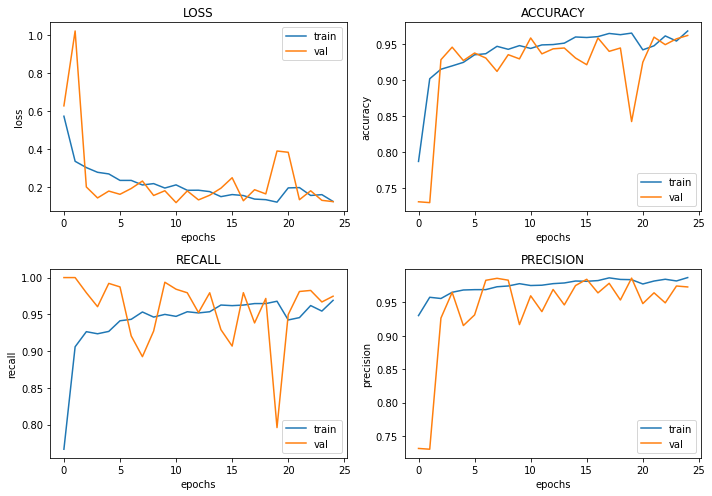

55/55 [==============================] - 3s 53ms/step - loss: 0.1368 - accuracy: 0.9624 - precision: 0.9733 - recall: 0.9748



[🔥 hyper parmas test] class_weight : {0: 1, 1: 2}

Model: "sequential_181"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_58 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d_123 (MaxPoolin (None, 90, 90, 16)        0         
_________________________________________________________________
sequential_182 (Sequential)  (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_183 (Sequential)  (None, 22, 22, 64)        7392      
_________________________________________________________________
seque

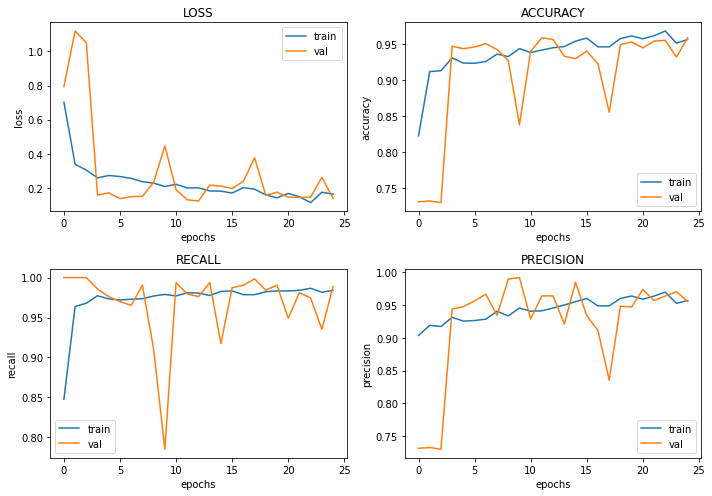

55/55 [==============================] - 3s 57ms/step - loss: 0.1362 - accuracy: 0.9579 - precision: 0.9614 - recall: 0.9811





In [216]:
metrix_w = {}

for cw in class_weight:
    print(f'[🔥 hyper parmas test] class_weight : {cw}\n')
    w_model = get_model_v2((180, 180, 3), kernel_size=base['kernel_size'])
    w_model.summary()
    history, train_time = train_model(w_model,
                                      D1['train'],
                                      D1['TRAIN_IMG_COUNT'] // BATCH_SIZE,
                                      D1['val'],
                                      D1['VAL_IMG_COUNT'] // BATCH_SIZE,
                                      base['epochs'],
                                      cw,
                                      verbose=0)
    show_history_plot(history)
    test_loss, test_acc, test_prec, test_recall = w_model.evaluate(D1['test'])
    
    metrix_w[cw] = {
        'recall' : test_recall,
        'accuracy' : test_acc,
        'loss' : test_loss, 
        'train time': train_time,
        'total params' : -1
    }
    print('\n\n')

In [247]:
metrix_cw={
    'Inverse proportion':{
        'recall' : 0.9276,
        'accuracy' : 0.9317,
        'loss' : 0.1866,
        'precision': 0.9768
    },
    '{0: 1, 1: 1}':{
        'recall' : 0.9843,
        'accuracy' : 0.9624,
        'loss' : 0.1459,
        'precision': 0.9645
    },
    '{0: 2, 1: 1}': {
        'recall' : 0.9748,
        'accuracy' : 0.9624,
        'loss' : 0.1368,
        'precision': 0.9733
    },
    '{0: 1, 1: 2}': {
        'recall' : 0.9811,
        'accuracy' : 0.9579,
        'loss' : 0.1362,
        'precision': 0.9614
    }
}

In [248]:
metrix_cw_df = pd.DataFrame(metrix_cw)
metrix_cw_df

,Inverse proportion,"{0: 1, 1: 1}","{0: 2, 1: 1}","{0: 1, 1: 2}"
recall,0.9276,0.9843,0.9748,0.9811
accuracy,0.9317,0.9624,0.9624,0.9579
loss,0.1866,0.1459,0.1368,0.1362
precision,0.9768,0.9645,0.9733,0.9614


/home/aiffel-dj1/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


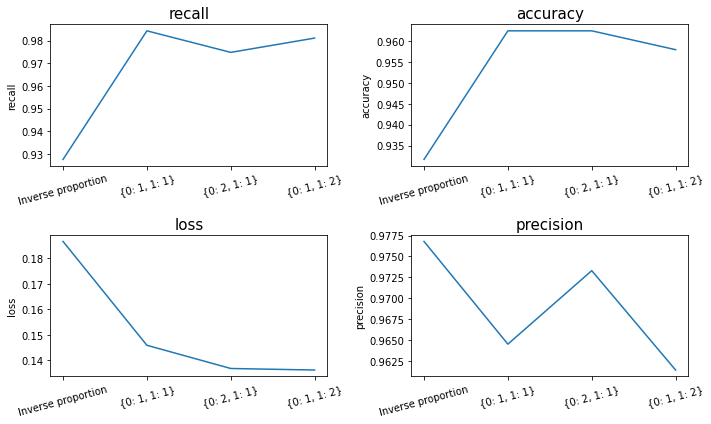

In [250]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))
axs = axs.ravel()

for i, idx in enumerate(metrix_cw_df.index):
    axs[i].plot(metrix_cw_df.loc[idx])
    axs[i].set_title(idx, fontsize=15)
    axs[i].set_ylabel(idx)
    axs[i].set_xticklabels(labels=list(metrix_cw_df.columns), rotation=15)
plt.tight_layout()
plt.show()

모든 지표를 종합적으로 보았을 때, class_weight가 {0: 2, 1: 1}일 때 가장 좋은 성능을 보이고 있다. 특히, train history plot가 이전 history plot들에 비해 상대적으로 안정적인 흐름을 보이는 것에 큰 점수를 주었다.

## STEP 3. 학습 데이터에 따른 모델 성능확인
---

- 하이퍼 파라미터 정의

In [29]:
class_weight = {0: 2, 1: 1}
epochs = 25

#### 1. D1을 input로하는 모델

- 모델 정의

In [253]:
d1_model = get_model_v2((180, 180, 3))
d1_model.summary()

Model: "sequential_189"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_60 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d_128 (MaxPoolin (None, 90, 90, 16)        0         
_________________________________________________________________
sequential_190 (Sequential)  (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_191 (Sequential)  (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_192 (Sequential)  (None, 11, 11, 128)       27072     
_________________________________________________________________
dropout_90 (Dropout)         (None, 11, 11, 128)    

- 모델 학습

In [256]:
d1_history, d1_train_time = train_model(d1_model,
                                        D1['train'],
                                        D1['TRAIN_IMG_COUNT'] // BATCH_SIZE,
                                        D1['val'],
                                        D1['VAL_IMG_COUNT'] // BATCH_SIZE,
                                        epochs,
                                        class_weight)

Epoch 1/25
256/256 - 34s - loss: 0.5651 - accuracy: 0.7939 - precision: 0.9229 - recall: 0.7835 - val_loss: 0.6638 - val_accuracy: 0.7338 - val_precision: 0.7338 - val_recall: 1.0000
Epoch 2/25
256/256 - 26s - loss: 0.3503 - accuracy: 0.8958 - precision: 0.9531 - recall: 0.9018 - val_loss: 1.0114 - val_accuracy: 0.7315 - val_precision: 0.7315 - val_recall: 1.0000
Epoch 3/25
256/256 - 26s - loss: 0.3003 - accuracy: 0.9187 - precision: 0.9618 - recall: 0.9255 - val_loss: 0.1629 - val_accuracy: 0.9375 - val_precision: 0.9459 - val_recall: 0.9699
Epoch 4/25
256/256 - 26s - loss: 0.2861 - accuracy: 0.9194 - precision: 0.9609 - recall: 0.9275 - val_loss: 0.1991 - val_accuracy: 0.9294 - val_precision: 0.9815 - val_recall: 0.9211
Epoch 5/25
256/256 - 26s - loss: 0.2604 - accuracy: 0.9246 - precision: 0.9669 - recall: 0.9284 - val_loss: 0.3203 - val_accuracy: 0.8796 - val_precision: 0.9871 - val_recall: 0.8463
Epoch 6/25
256/256 - 27s - loss: 0.2500 - accuracy: 0.9294 - precision: 0.9656 - reca

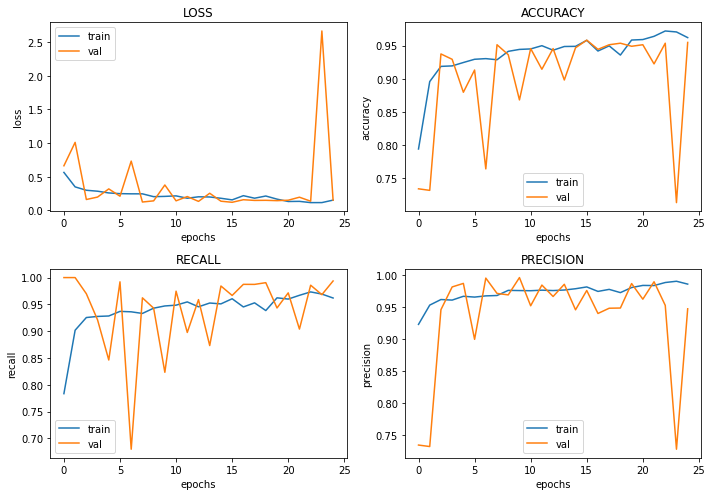

In [257]:
show_history_plot(d1_history)

- 모델 평가

In [258]:
d1_test_loss, d1_test_acc, d1_test_prec, d1_test_recall = d1_model.evaluate(D1['test'])

55/55 [==============================] - 3s 58ms/step - loss: 0.1383 - accuracy: 0.9624 - precision: 0.9574 - recall: 0.9921


#### 2. D2를 input으로하는 모델

- 모델 정의

In [254]:
d2_model = get_model_v2((180, 180, 3))
d2_model.summary()

Model: "sequential_197"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_62 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d_133 (MaxPoolin (None, 90, 90, 16)        0         
_________________________________________________________________
sequential_198 (Sequential)  (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_199 (Sequential)  (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_200 (Sequential)  (None, 11, 11, 128)       27072     
_________________________________________________________________
dropout_95 (Dropout)         (None, 11, 11, 128)    

- 모델 학습

In [259]:
d2_history, d2_train_time = train_model(d2_model,
                                        D2['train'],
                                        D2['TRAIN_IMG_COUNT'] // BATCH_SIZE,
                                        D2['val'],
                                        D2['VAL_IMG_COUNT'] // BATCH_SIZE,
                                        epochs,
                                        class_weight)

Epoch 1/25
512/512 - 33s - loss: 0.5194 - accuracy: 0.8260 - precision: 0.9294 - recall: 0.8225 - val_loss: 1.1628 - val_accuracy: 0.7517 - val_precision: 0.7517 - val_recall: 1.0000
Epoch 2/25
512/512 - 27s - loss: 0.3568 - accuracy: 0.8945 - precision: 0.9506 - recall: 0.9013 - val_loss: 0.5268 - val_accuracy: 0.7741 - val_precision: 0.7691 - val_recall: 0.9985
Epoch 3/25
512/512 - 26s - loss: 0.3050 - accuracy: 0.9193 - precision: 0.9610 - recall: 0.9262 - val_loss: 0.2248 - val_accuracy: 0.8985 - val_precision: 0.8851 - val_recall: 0.9939
Epoch 4/25
512/512 - 27s - loss: 0.3013 - accuracy: 0.9154 - precision: 0.9588 - recall: 0.9231 - val_loss: 0.1443 - val_accuracy: 0.9518 - val_precision: 0.9701 - val_recall: 0.9656
Epoch 5/25
512/512 - 27s - loss: 0.2770 - accuracy: 0.9271 - precision: 0.9653 - recall: 0.9329 - val_loss: 0.1398 - val_accuracy: 0.9484 - val_precision: 0.9664 - val_recall: 0.9649
Epoch 6/25
512/512 - 28s - loss: 0.2603 - accuracy: 0.9293 - precision: 0.9683 - reca

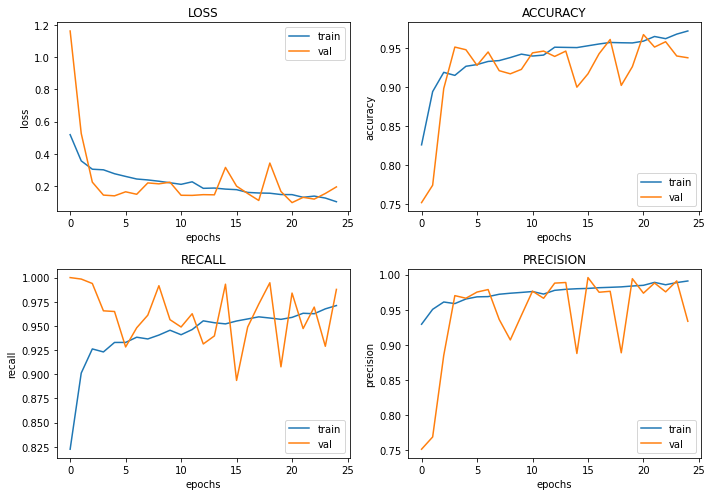

In [260]:
show_history_plot(d2_history)

- 모델 평가

In [261]:
d2_test_loss, d2_test_acc, d2_test_prec, d2_test_recall = d2_model.evaluate(D2['test'])

110/110 [==============================] - 4s 32ms/step - loss: 0.2133 - accuracy: 0.9380 - precision: 0.9330 - recall: 0.9860


#### 3. D3을 input으로하는 모델

- 모델 정의

In [28]:
d3_model = get_model_v2((360, 360, 3))
d3_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 360, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 360, 360, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 180, 180, 16)      0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 90, 90, 32)        2160      
_________________________________________________________________
sequential_2 (Sequential)    (None, 45, 45, 64)        7392      
_________________________________________________________________
sequential_3 (Sequential)    (None, 22, 22, 128)       27072     
_________________________________________________________________
dropout (Dropout)            (None, 22, 22, 128)       0

- 모델 학습

In [30]:
d3_history, d3_train_time = train_model(d3_model,
                                        D3['train'],
                                        D3['TRAIN_IMG_COUNT'] // BATCH_SIZE,
                                        D3['val'],
                                        D3['VAL_IMG_COUNT'] // BATCH_SIZE,
                                        epochs,
                                        class_weight)

Epoch 1/25
256/256 - 59s - loss: 0.4986 - accuracy: 0.8396 - precision: 0.9421 - recall: 0.8316 - val_loss: 0.5849 - val_accuracy: 0.7350 - val_precision: 0.7350 - val_recall: 1.0000
Epoch 2/25
256/256 - 50s - loss: 0.3555 - accuracy: 0.9006 - precision: 0.9534 - recall: 0.9085 - val_loss: 0.6606 - val_accuracy: 0.7326 - val_precision: 0.7326 - val_recall: 1.0000
Epoch 3/25
256/256 - 50s - loss: 0.3099 - accuracy: 0.9155 - precision: 0.9597 - recall: 0.9231 - val_loss: 0.1680 - val_accuracy: 0.9340 - val_precision: 0.9632 - val_recall: 0.9465
Epoch 4/25
256/256 - 50s - loss: 0.3006 - accuracy: 0.9146 - precision: 0.9610 - recall: 0.9205 - val_loss: 0.2486 - val_accuracy: 0.9167 - val_precision: 0.9861 - val_recall: 0.8987
Epoch 5/25
256/256 - 49s - loss: 0.2665 - accuracy: 0.9263 - precision: 0.9654 - recall: 0.9324 - val_loss: 1.0406 - val_accuracy: 0.7419 - val_precision: 0.7398 - val_recall: 1.0000
Epoch 6/25
256/256 - 49s - loss: 0.2485 - accuracy: 0.9326 - precision: 0.9692 - reca

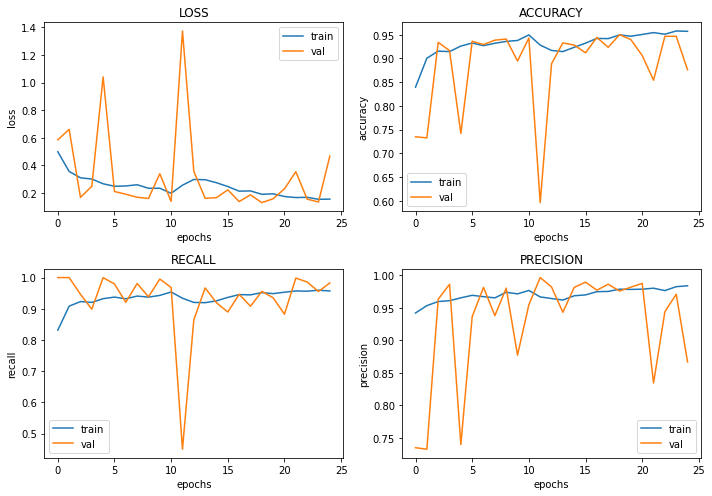

In [31]:
show_history_plot(d3_history)

- 모델 평가

In [32]:
d3_test_loss, d3_test_acc, d3_test_prec, d3_test_recall = d3_model.evaluate(D3['test'])

55/55 [==============================] - 4s 71ms/step - loss: 0.4344 - accuracy: 0.8793 - precision: 0.8699 - recall: 0.9795


#### 4. 지표비교

In [34]:
metrix_data = {
    'D1': {
        'recall' : 0.9921,
        'accuracy' : 0.9624,
        'loss' : 0.1383, 
        'total params' : 3496801
    },
    'D2': {
        'recall' : 0.9860,
        'accuracy' : 0.9380,
        'loss' : 0.2133, 
        'total params' : 3496801
    },
    'D3': {
        'recall' : d3_test_recall,
        'accuracy' : d3_test_acc,
        'loss' : d3_test_loss, 
        'total params' : 16079713
    }
}
metrix_data

{'D1': {'recall': 0.9921,
  'accuracy': 0.9624,
  'loss': 0.1383,
  'total params': 3496801},
 'D2': {'recall': 0.986,
  'accuracy': 0.938,
  'loss': 0.2133,
  'total params': 3496801},
 'D3': {'recall': 0.9795275330543518,
  'accuracy': 0.8792710900306702,
  'loss': 0.4344211518764496,
  'total params': 16079713}}

In [35]:
pd.options.display.float_format = '{:.4f}'.format
metrix_data_df = pd.DataFrame(metrix_data)
metrix_data_df

,D1,D2,D3
recall,0.9921,0.9860,0.9795
accuracy,0.9624,0.9380,0.8793
loss,0.1383,0.2133,0.4344
total params,3496801.0000,3496801.0000,16079713.0000


/home/aiffel-dj1/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


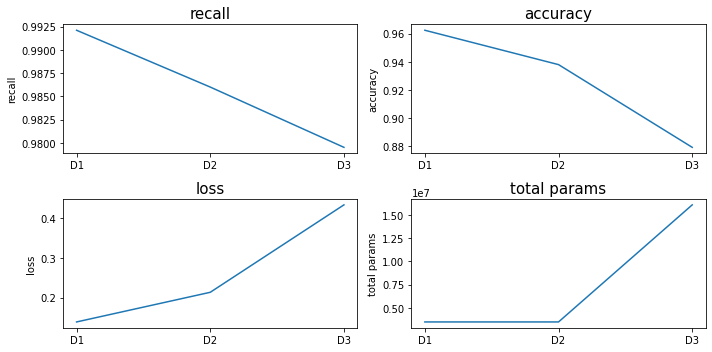

In [40]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5))
axs = axs.ravel()

for i, idx in enumerate(metrix_data_df.index):
    axs[i].plot(metrix_data_df.loc[idx])
    axs[i].set_title(idx, fontsize=15)
    axs[i].set_ylabel(idx)
    axs[i].set_xticklabels(labels=list(metrix_data_df.columns))
plt.tight_layout()
plt.show()

어느 상황이 더 ***좋은*** 모델인지 판단하기 어렵다. 현재 프로젝트에서 accuracy와 recall는 거의 100%에 가까운 과도하게 높은 값이 등장하고 있다. 이는 모델이 최적화 되었다기 보다는 어쩌면 과접합된 결과물이라고 해석할 수 있다. 하지만, 모델이 과접합 되었는지를 판별하기 위해서 training history를 그래프로 그려 확인하였지만, 그래프가 너무 불안정하여 해석이 어려웠다. accuracy 그래프의 후반부에서 validation accuary과 train accuracy 사이의 간격이 벌어지는 것이 overfitting 되지 않는가는 근거인지 그냥 그래프가 불안정 한 것인지 판별하는 것이 내가 가진 지식으로는 거의 불가능 했기 때문이다.

이번 실험의 결과도 비슷한 맥락으로 어느 모델이 더 좋은지에 대한 판단이서지 않는다. 지표상으로 D1이 가장 좋다. 하지만, D2가 만약 D1이 가지고 있던 과접합 문제를 일정 부분 해결하면서 accuracy가 떨어진 것이라면, D2가 더 나은 모델이라고 할 수 있을 것이다.

## STEP 4. 결론
---

### 프로젝트 평가
1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다. 모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.
    - 여러 구성의 모델을 수립하여 학습을 진행하였는데, 많은 수의 모델들의 지표가 수렴해 가기는 하나, 그 추세가 매우 불안정하다.
2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다. regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.
    - 다양한 실험을 진행하였고, 해당 내용들은 아래의 표와 같이 정리 될 수 있다.
    - ![09_experiment_result.png](./assets/09_experiment_result.png)
3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.Accuracy 기준 85%에 도달하였다.
    - 실험 과정에서 도달한 최고 accuracy는 96.24%였고, 최저 accuracy는 0.7232였다.

### 회고
- 파라미터와 학습시간 : 이번 프로젝트를 진행하기 전까지, 모델에 파라미터가 많으면 연산량이 많아지므로 학습시간이 오래 걸릴거라고 생각했었다. 하지만 실험결과 모델의 구조나 다른 요소들에 의해서 파라미터가 증가할 때, 학습시간이 증가할 수 있겠지만, 둘 사이에 무조건 같이 증가한다는 선형적 관계가 있는것은 아니다었다. 모델의 파라미터, 사용되는 메모리, 모델의 학습시간, 모델의 연상량 등에 대해서 생각해 보는 시간이 될 수 있었다. 추가적으로 이에 대해서 모델의 유형 별로 정리해 보는 시간을 가지면 좋을 듯 하다.
- 여러 요소를 넣었다 뺐다하면서 실행을 진행하였으나, accuracy에 가장 큰 영향을 미친 것은 사실 random seed였다. 동일한 코드에서 seed를 고정시켜 주지 않고 랜덤으로 맡겼을 때, accuracy는 76% 가량을 기록하였었는데, 이를 2021로 고정하자마자 90%가 넘는 accuracy를 기록하였다. seed의 영향력에 대해서는 알고 있었지만, 이렇게 직접적으로 그 힘을 눈으로 확인하니 상당히 허탈하면서도, 캐글 같은 대회에 참가하게 된다면 seed를 seach로 찾아봐야겠다는 꼼수가 떠올랐다.

## ref
---
- [tf.keras.layers.SeparableConv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SeparableConv2D)
- [tf.keras.layers.DepthwiseConv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/DepthwiseConv2D)
- [[Deep Learning] 딥러닝에서 사용되는 다양한 Convolution 기법들](https://eehoeskrap.tistory.com/431)
- [A Comprehensive Introduction to Different Types of Convolutions in Deep Learning](https://towardsdatascience.com/a-comprehensive-introduction-to-different-types-of-convolutions-in-deep-learning-669281e58215)
- [About Convolutional Layer and Convolution Kernel](https://www.sicara.ai/blog/2019-10-31-convolutional-layer-convolution-kernel)
- [여러 컨볼루션 레이어 테크닉과 경량화 기법들](https://www.slideshare.net/ssuser6135a1/ss-106656779)
- [[데이터 사이언스]"Ablation study"란 무엇인가](https://fintecuriosity-11.tistory.com/73)
- [Lecture 11: CNNs in Practice](https://ys-cs17.tistory.com/20)
- [Image Data Augmentation 기초 이론/코드](https://dalpo0814.tistory.com/17)
- [데이터 증강](https://www.tensorflow.org/tutorials/images/data_augmentation?hl=ko)
- [데이터 증강을 통한 딥 러닝 네트워크 정확도 향상 방법](http://www.riss.kr/search/detail/DetailView.do?p_mat_type=be54d9b8bc7cdb09&control_no=4d67d787761a824effe0bdc3ef48d419&outLink=K)
- [Deep Learning in Healthcare — X-Ray Imaging (Part 5-Data Augmentation and Image Normalization)](https://towardsdatascience.com/deep-learning-in-healthcare-x-ray-imaging-part-5-data-augmentation-and-image-normalization-1ead1c02cfe3)